In [138]:
import os
import numpy as np
import pandas as pd
from pandas.core.common import flatten
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import platform
from tqdm import tqdm
import random
import glob
import copy
from dataclasses import dataclass
import time
from collections import Counter
from collections import defaultdict
import gc

import sklearn
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, roc_auc_score

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision
import torchvision.models as models

import timm

import warnings
warnings.filterwarnings("ignore")

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [139]:
!nvidia-smi

Fri Mar  3 14:32:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |  11056MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [140]:
@dataclass
class CONFIG:
    TRAIN_PATH = "/kaggle/input/gsoc-deep-lense-task-1/dataset/train"
    VAL_PATH = "/kaggle/input/gsoc-deep-lense-task-1/dataset/val"
    MODEL_NAMES = ['densenet161']
    BATCH_SIZE = 64
    LEARNING_RATE = 1e-4
#     EPOCHS = 2
    EPOCHS = 6

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
def get_device():
    global DEVICE
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
        DEVICE = torch.device("cuda:0")
    else:
        print("\n[INFO] GPU not found. Using CPU: {}\n".format(platform.processor()))
        DEVICE = torch.device("cpu")
    
RANDOM_SEED = 42
set_seed(RANDOM_SEED)
get_device()

[INFO] Using GPU: Tesla T4



In [141]:
train_image_paths = []
val_image_paths = []
classes = []

for train_data_path in glob.glob(CONFIG.TRAIN_PATH + "/*"):
    classes.append(train_data_path.split("/")[-1])
    train_image_paths.append(glob.glob(train_data_path + "/*"))
    
for val_data_path in glob.glob(CONFIG.VAL_PATH + "/*"):
    val_image_paths.append(glob.glob(val_data_path + "/*"))
    
# print(train_image_paths)
# print(classes)

train_image_paths = list(flatten(train_image_paths))
val_image_paths = list(flatten(val_image_paths))


# print(f"Train Image Path: {train_image_paths[0].split('/')[-2]}")
# print(f"Class: {classes[0]}")

print(f"Train Size: {len(train_image_paths)}\nVal Size: {len(val_image_paths)}")

Train Size: 30000
Val Size: 7500


In [142]:
idx_to_class = {i: j for i, j in enumerate(classes)}
class_to_idx = {value: key for key, value in idx_to_class.items()}

print(f"Index to class dictionary: {idx_to_class}")
print(f"Class to index dictionary: {class_to_idx}")

Index to class dictionary: {0: 'no', 1: 'vort', 2: 'sphere'}
Class to index dictionary: {'no': 0, 'vort': 1, 'sphere': 2}


In [144]:
class GSoCDeepLensePrivateDatasetTask1(Dataset):
    
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = np.load(image_filepath)
        
        label = image_filepath.split("/")[-2]
        label = class_to_idx[label]
            
        return image, label

train_dataset = GSoCDeepLensePrivateDatasetTask1(image_paths=train_image_paths, transform=False)
val_dataset = GSoCDeepLensePrivateDatasetTask1(image_paths=val_image_paths, transform=False)

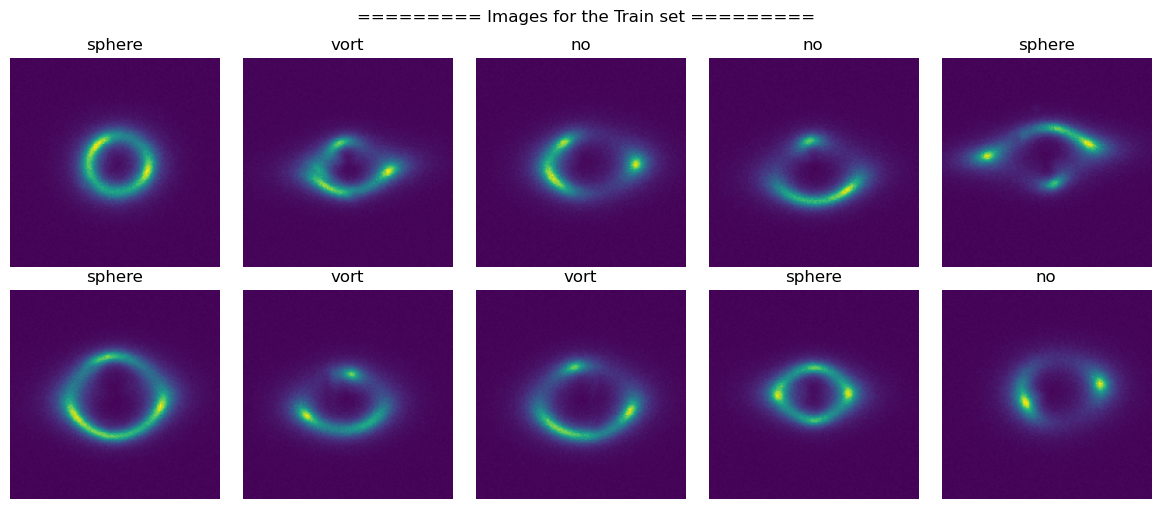

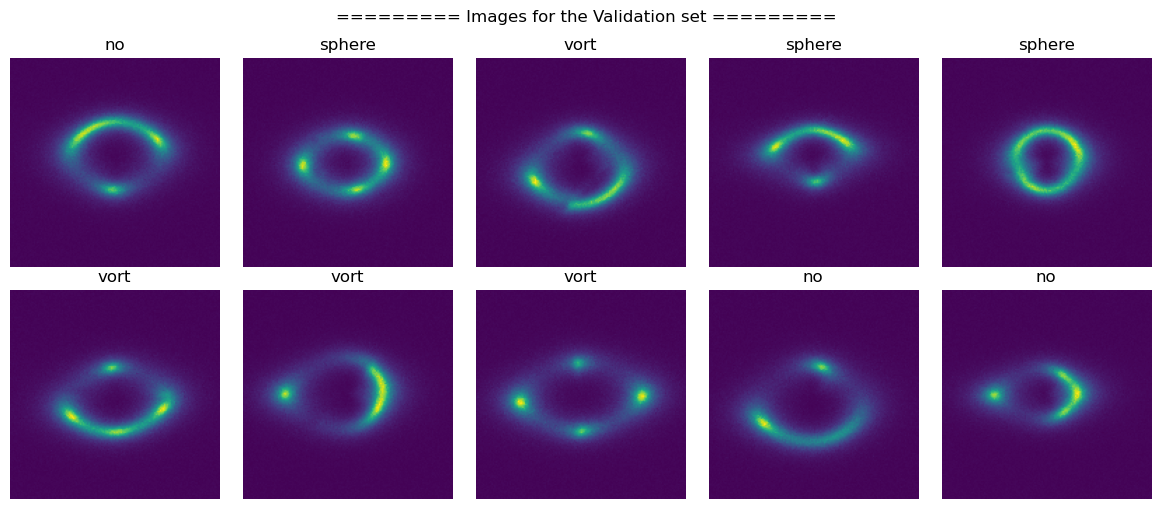

In [145]:
def visualize_images(dataset_input, dataset_type, samples, cols):
    
    dataset_len = len(dataset_input)
    dataset = dataset_input
    
    rows = samples // cols
    
    fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize=(12, 8))
    fig.suptitle(f"========= Images for the {dataset_type.title()} set =========", y=0.9)
    
    for i in range(samples):
        idx = np.random.randint(0, dataset_len)
        image, label = dataset[idx]
        image = image.swapaxes(0, 1)
        image = image.swapaxes(1, 2)
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[label])
        
    plt.tight_layout(rect=[0, 0.2, 0.99, 0.975], h_pad=2.1, pad=1.7)
    plt.show()
    
visualize_images(dataset_input=train_dataset, dataset_type="train", samples=10, cols=5)
visualize_images(dataset_input=val_dataset, dataset_type="validation", samples=10, cols=5)

In [146]:
def make_data_loader(dataset, shuffle):
    loader = DataLoader(dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=shuffle)
    
    return loader

train_loader = make_data_loader(dataset=train_dataset, shuffle=True)
val_loader = make_data_loader(dataset=val_dataset, shuffle=False)

In [147]:
class TransferLearningModel(nn.Module):
    
    def __init__(self, n_classes):
        super(TransferLearningModel, self).__init__()
        self.transfer_learning_model = timm.create_model(CONFIG.MODEL_NAMES[0], pretrained=True, in_chans=1)
        
        for param in self.transfer_learning_model.parameters():
            param.requires_grad = True
            
        self.classifier = nn.Sequential(
            nn.Linear(2208 * 4 * 4, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.25),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.25),
            nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        x = self.transfer_learning_model.forward_features(x)
        x = x.view(-1, 2208 * 4 * 4)
        x = self.classifier(x)
        
        return x

In [149]:
model = TransferLearningModel(len(classes))
model = model.to(DEVICE)

In [151]:
def train_one_epoch(model, optimizer, data_loader, device):
    
    model.train()
    
    total = 0
    correct = 0
    train_accuracy = []
    train_loss = []
    
    for i, data in enumerate(tqdm(data_loader)):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        y_pred = model(images.float())
        loss = criterion(y_pred, labels)
        
        _, predicted = torch.max(y_pred.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if(i % 10 == 0):
            print(f"Loss: {loss}, Accuracy: {accuracy}")
        
        train_accuracy.append(torch.tensor(accuracy))
        train_loss.append(torch.tensor(loss))
        
    return train_accuracy, train_loss

In [153]:
def test_model(model, data_loader, device):
    
    model.eval()
    
    total = 0
    correct = 0
    val_accuracy = []
    val_loss = []
    
    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader)):
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
        
            y_pred = model(images.float())
            loss = criterion(y_pred, labels)

            _, predicted = torch.max(y_pred.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            
            val_accuracy.append(torch.tensor(accuracy))
            val_loss.append(torch.tensor(loss))
                    
    return val_accuracy, val_loss

In [154]:
def convert_tensor_list_to_single_mean_value(tensor_list):

    tensor_list = [tensor.detach().cpu().numpy() for tensor in tensor_list]
    
    return np.mean(tensor_list)

In [155]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG.LEARNING_RATE)

In [156]:
%%time

history = defaultdict(list)
best_accuracy = 0
model_name = CONFIG.MODEL_NAMES[0]

for epoch in range(CONFIG.EPOCHS):
    print(f"Epoch {epoch + 1} / {CONFIG.EPOCHS}")
    print('=' * 10)
    
    train_accuracy, train_loss = train_one_epoch(model=model, optimizer=optimizer, data_loader=train_loader, device=DEVICE)
    train_accuracy = convert_tensor_list_to_single_mean_value(tensor_list=train_accuracy)
    train_loss = convert_tensor_list_to_single_mean_value(tensor_list=train_loss)
    print(f'Train loss: {train_loss}\nTrain accuracy: {train_accuracy}\n')
    
    val_accuracy, val_loss = test_model(model=model, data_loader=val_loader, device=DEVICE)
    val_accuracy = convert_tensor_list_to_single_mean_value(tensor_list=val_accuracy)
    val_loss = convert_tensor_list_to_single_mean_value(tensor_list=val_loss)
    print(f'Val loss: {val_loss}\nVal accuracy: {val_accuracy}\n')
    
    history['train_acc'].append(train_accuracy)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_accuracy)
    history['val_loss'].append(val_loss) 
    
    if(val_accuracy > best_accuracy):
        torch.save(model.state_dict(), 
                   f'{model_name}_epochs_{CONFIG.EPOCHS}_batchsize_{CONFIG.BATCH_SIZE}_lr_{CONFIG.LEARNING_RATE}.bin')
        best_accuracy = val_accuracy

Epoch 1 / 6


  0%|          | 1/469 [00:01<10:52,  1.39s/it]

Loss: 1.2236188650131226, Accuracy: 37.5


  2%|▏         | 11/469 [00:11<07:47,  1.02s/it]

Loss: 1.2415053844451904, Accuracy: 34.80113636363637


  4%|▍         | 21/469 [00:21<07:26,  1.00it/s]

Loss: 1.157540202140808, Accuracy: 36.30952380952381


  7%|▋         | 31/469 [00:31<07:25,  1.02s/it]

Loss: 1.1959019899368286, Accuracy: 36.189516129032256


  9%|▊         | 41/469 [00:41<06:59,  1.02it/s]

Loss: 1.160788893699646, Accuracy: 36.77591463414634


 11%|█         | 51/469 [00:51<06:55,  1.01it/s]

Loss: 1.1747411489486694, Accuracy: 36.7953431372549


 13%|█▎        | 61/469 [01:00<06:38,  1.02it/s]

Loss: 1.1472622156143188, Accuracy: 36.80840163934426


 15%|█▌        | 71/469 [01:10<06:24,  1.04it/s]

Loss: 1.0815773010253906, Accuracy: 37.30193661971831


 17%|█▋        | 81/469 [01:20<06:18,  1.02it/s]

Loss: 1.1668968200683594, Accuracy: 37.673611111111114


 19%|█▉        | 91/469 [01:30<06:09,  1.02it/s]

Loss: 1.0784567594528198, Accuracy: 38.01510989010989


 22%|██▏       | 101/469 [01:39<05:54,  1.04it/s]

Loss: 1.1694748401641846, Accuracy: 38.49009900990099


 24%|██▎       | 111/469 [01:49<05:51,  1.02it/s]

Loss: 0.9585064649581909, Accuracy: 39.07657657657658


 26%|██▌       | 121/469 [01:59<05:40,  1.02it/s]

Loss: 1.047760248184204, Accuracy: 39.87603305785124


 28%|██▊       | 131/469 [02:08<05:30,  1.02it/s]

Loss: 1.0450048446655273, Accuracy: 40.291030534351144


 30%|███       | 141/469 [02:18<05:14,  1.04it/s]

Loss: 0.9907380938529968, Accuracy: 40.95744680851064


 32%|███▏      | 151/469 [02:27<04:57,  1.07it/s]

Loss: 1.0606884956359863, Accuracy: 41.65976821192053


 34%|███▍      | 161/469 [02:37<04:45,  1.08it/s]

Loss: 0.9428207874298096, Accuracy: 42.51746894409938


 36%|███▋      | 171/469 [02:46<04:35,  1.08it/s]

Loss: 0.9032643437385559, Accuracy: 43.06469298245614


 39%|███▊      | 181/469 [02:55<04:28,  1.07it/s]

Loss: 0.8164114356040955, Accuracy: 43.75


 41%|████      | 191/469 [03:05<04:19,  1.07it/s]

Loss: 0.8677209615707397, Accuracy: 44.43717277486911


 43%|████▎     | 201/469 [03:14<04:08,  1.08it/s]

Loss: 0.883612334728241, Accuracy: 45.25031094527363


 45%|████▍     | 211/469 [03:23<04:01,  1.07it/s]

Loss: 0.928059995174408, Accuracy: 45.7864336492891


 47%|████▋     | 221/469 [03:33<03:53,  1.06it/s]

Loss: 0.8401026129722595, Accuracy: 46.47907239819005


 49%|████▉     | 231/469 [03:42<03:40,  1.08it/s]

Loss: 0.9068547487258911, Accuracy: 47.17261904761905


 51%|█████▏    | 241/469 [03:51<03:32,  1.07it/s]

Loss: 0.5603799819946289, Accuracy: 47.990145228215766


 54%|█████▎    | 251/469 [04:01<03:23,  1.07it/s]

Loss: 0.8300315737724304, Accuracy: 48.773655378486055


 56%|█████▌    | 261/469 [04:10<03:15,  1.06it/s]

Loss: 0.7722450494766235, Accuracy: 49.503113026819925


 58%|█████▊    | 271/469 [04:19<03:06,  1.06it/s]

Loss: 0.7081723213195801, Accuracy: 50.21909594095941


 60%|█████▉    | 281/469 [04:29<02:54,  1.08it/s]

Loss: 0.6212309002876282, Accuracy: 50.88967971530249


 62%|██████▏   | 291/469 [04:38<02:47,  1.06it/s]

Loss: 0.7758092880249023, Accuracy: 51.52491408934708


 64%|██████▍   | 301/469 [04:47<02:38,  1.06it/s]

Loss: 0.575598418712616, Accuracy: 52.232142857142854


 66%|██████▋   | 311/469 [04:57<02:31,  1.04it/s]

Loss: 0.6016306281089783, Accuracy: 52.89389067524116


 68%|██████▊   | 321/469 [05:07<02:24,  1.02it/s]

Loss: 0.717057466506958, Accuracy: 53.514408099688474


 71%|███████   | 331/469 [05:16<02:11,  1.05it/s]

Loss: 0.7806690335273743, Accuracy: 54.24848942598187


 73%|███████▎  | 341/469 [05:26<02:02,  1.04it/s]

Loss: 0.5391648411750793, Accuracy: 54.90285923753666


 75%|███████▍  | 351/469 [05:35<01:53,  1.04it/s]

Loss: 0.47690442204475403, Accuracy: 55.44426638176638


 77%|███████▋  | 361/469 [05:45<01:43,  1.04it/s]

Loss: 0.7684609889984131, Accuracy: 56.04224376731302


 79%|███████▉  | 371/469 [05:55<01:35,  1.03it/s]

Loss: 0.46887147426605225, Accuracy: 56.620619946091644


 81%|████████  | 381/469 [06:04<01:25,  1.03it/s]

Loss: 0.48580223321914673, Accuracy: 57.164534120734906


 83%|████████▎ | 391/469 [06:14<01:15,  1.04it/s]

Loss: 0.4610627591609955, Accuracy: 57.71659207161125


 86%|████████▌ | 401/469 [06:24<01:06,  1.02it/s]

Loss: 0.593209981918335, Accuracy: 58.194357855361595


 88%|████████▊ | 411/469 [06:33<00:56,  1.03it/s]

Loss: 0.588691771030426, Accuracy: 58.732512165450125


 90%|████████▉ | 421/469 [06:43<00:46,  1.03it/s]

Loss: 0.5211418867111206, Accuracy: 59.21540973871734


 92%|█████████▏| 431/469 [06:53<00:37,  1.03it/s]

Loss: 0.5310988426208496, Accuracy: 59.69040023201856


 94%|█████████▍| 441/469 [07:02<00:27,  1.00it/s]

Loss: 0.42257997393608093, Accuracy: 60.165107709750565


 96%|█████████▌| 451/469 [07:12<00:17,  1.01it/s]

Loss: 0.47692355513572693, Accuracy: 60.62915742793792


 98%|█████████▊| 461/469 [07:22<00:07,  1.00it/s]

Loss: 0.39667633175849915, Accuracy: 61.012066160520604


100%|██████████| 469/469 [07:30<00:00,  1.04it/s]


Train loss: 0.8162971138954163
Train accuracy: 47.703033447265625



100%|██████████| 118/118 [00:42<00:00,  2.77it/s]


Val loss: 0.5606603026390076
Val accuracy: 90.35256958007812

Epoch 2 / 6


  0%|          | 1/469 [00:00<06:41,  1.17it/s]

Loss: 0.4091632664203644, Accuracy: 84.375


  2%|▏         | 11/469 [00:09<06:30,  1.17it/s]

Loss: 0.35493355989456177, Accuracy: 84.6590909090909


  4%|▍         | 21/469 [00:17<06:23,  1.17it/s]

Loss: 0.4298810660839081, Accuracy: 84.15178571428571


  7%|▋         | 31/469 [00:26<06:22,  1.15it/s]

Loss: 0.5305164456367493, Accuracy: 83.31653225806451


  9%|▊         | 41/469 [00:35<06:12,  1.15it/s]

Loss: 0.4430232048034668, Accuracy: 82.69817073170732


 11%|█         | 51/469 [00:44<06:04,  1.15it/s]

Loss: 0.3644629418849945, Accuracy: 83.21078431372548


 13%|█▎        | 61/469 [00:52<05:59,  1.14it/s]

Loss: 0.36230799555778503, Accuracy: 83.35040983606558


 15%|█▌        | 71/469 [01:01<05:47,  1.15it/s]

Loss: 0.5421440005302429, Accuracy: 83.45070422535211


 17%|█▋        | 81/469 [01:10<05:39,  1.14it/s]

Loss: 0.3856918215751648, Accuracy: 83.35262345679013


 19%|█▉        | 91/469 [01:19<05:43,  1.10it/s]

Loss: 0.3648555874824524, Accuracy: 83.56799450549451


 22%|██▏       | 101/469 [01:28<05:27,  1.12it/s]

Loss: 0.48759347200393677, Accuracy: 83.74071782178218


 24%|██▎       | 111/469 [01:36<05:15,  1.13it/s]

Loss: 0.4899676740169525, Accuracy: 83.64301801801801


 26%|██▌       | 121/469 [01:45<05:07,  1.13it/s]

Loss: 0.3835332691669464, Accuracy: 83.62603305785125


 28%|██▊       | 131/469 [01:54<05:06,  1.10it/s]

Loss: 0.4579508900642395, Accuracy: 83.75477099236642


 30%|███       | 141/469 [02:03<04:54,  1.11it/s]

Loss: 0.4690771698951721, Accuracy: 83.76551418439716


 32%|███▏      | 151/469 [02:12<04:47,  1.10it/s]

Loss: 0.27166905999183655, Accuracy: 83.7955298013245


 34%|███▍      | 161/469 [02:21<04:37,  1.11it/s]

Loss: 0.3886384963989258, Accuracy: 83.89945652173913


 36%|███▋      | 171/469 [02:30<04:40,  1.06it/s]

Loss: 0.28040751814842224, Accuracy: 83.98209064327486


 39%|███▊      | 181/469 [02:40<04:37,  1.04it/s]

Loss: 0.40163910388946533, Accuracy: 84.0728591160221


 41%|████      | 191/469 [02:49<04:21,  1.06it/s]

Loss: 0.4428884983062744, Accuracy: 83.98232984293193


 43%|████▎     | 201/469 [02:59<04:22,  1.02it/s]

Loss: 0.49743717908859253, Accuracy: 83.9707711442786


 45%|████▍     | 211/469 [03:09<04:04,  1.06it/s]

Loss: 0.4712008833885193, Accuracy: 84.10841232227489


 47%|████▋     | 221/469 [03:18<03:58,  1.04it/s]

Loss: 0.2677088975906372, Accuracy: 84.24066742081448


 49%|████▉     | 231/469 [03:28<03:43,  1.07it/s]

Loss: 0.4139536917209625, Accuracy: 84.40882034632034


 51%|█████▏    | 241/469 [03:38<03:48,  1.00s/it]

Loss: 0.3897070288658142, Accuracy: 84.42038381742739


 54%|█████▎    | 251/469 [03:47<03:26,  1.06it/s]

Loss: 0.4691866636276245, Accuracy: 84.53685258964144


 56%|█████▌    | 261/469 [03:57<03:19,  1.04it/s]

Loss: 0.4626061022281647, Accuracy: 84.50670498084291


 58%|█████▊    | 271/469 [04:07<03:11,  1.04it/s]

Loss: 0.43189537525177, Accuracy: 84.49031365313652


 60%|█████▉    | 281/469 [04:16<02:51,  1.09it/s]

Loss: 0.3233770430088043, Accuracy: 84.54181494661921


 62%|██████▏   | 291/469 [04:25<02:44,  1.08it/s]

Loss: 0.25205183029174805, Accuracy: 84.57903780068729


 64%|██████▍   | 301/469 [04:34<02:35,  1.08it/s]

Loss: 0.33064889907836914, Accuracy: 84.65531561461793


 66%|██████▋   | 311/469 [04:43<02:24,  1.10it/s]

Loss: 0.6146852970123291, Accuracy: 84.60610932475885


 68%|██████▊   | 321/469 [04:53<02:15,  1.09it/s]

Loss: 0.3348408639431, Accuracy: 84.63298286604362


 71%|███████   | 331/469 [05:02<02:06,  1.09it/s]

Loss: 0.33905360102653503, Accuracy: 84.65823262839879


 73%|███████▎  | 341/469 [05:11<01:58,  1.08it/s]

Loss: 0.3104631304740906, Accuracy: 84.73240469208211


 75%|███████▍  | 351/469 [05:20<01:48,  1.08it/s]

Loss: 0.3697856068611145, Accuracy: 84.80235042735043


 77%|███████▋  | 361/469 [05:29<01:39,  1.09it/s]

Loss: 0.3843846619129181, Accuracy: 84.85543628808864


 79%|███████▉  | 371/469 [05:39<01:31,  1.07it/s]

Loss: 0.2673751711845398, Accuracy: 84.893025606469


 81%|████████  | 381/469 [05:48<01:21,  1.08it/s]

Loss: 0.30889424681663513, Accuracy: 84.97785433070867


 83%|████████▎ | 391/469 [05:57<01:12,  1.08it/s]

Loss: 0.2550660967826843, Accuracy: 85.082320971867


 86%|████████▌ | 401/469 [06:07<01:04,  1.05it/s]

Loss: 0.3854333758354187, Accuracy: 85.10754364089776


 88%|████████▊ | 411/469 [06:16<00:54,  1.07it/s]

Loss: 0.35779011249542236, Accuracy: 85.21137469586375


 90%|████████▉ | 421/469 [06:25<00:45,  1.06it/s]

Loss: 0.4722476899623871, Accuracy: 85.25460213776722


 92%|█████████▏| 431/469 [06:35<00:35,  1.06it/s]

Loss: 0.3941437900066376, Accuracy: 85.31395011600928


 94%|█████████▍| 441/469 [06:44<00:26,  1.08it/s]

Loss: 0.3833394944667816, Accuracy: 85.30328798185941


 96%|█████████▌| 451/469 [06:53<00:16,  1.08it/s]

Loss: 0.291679710149765, Accuracy: 85.3485310421286


 98%|█████████▊| 461/469 [07:03<00:07,  1.08it/s]

Loss: 0.43940338492393494, Accuracy: 85.4189262472885


100%|██████████| 469/469 [07:10<00:00,  1.09it/s]


Train loss: 0.3872215449810028
Train accuracy: 84.33570098876953



100%|██████████| 118/118 [00:42<00:00,  2.75it/s]


Val loss: 0.33007821440696716
Val accuracy: 91.70787048339844

Epoch 3 / 6


  0%|          | 1/469 [00:00<06:41,  1.17it/s]

Loss: 0.31336963176727295, Accuracy: 85.9375


  2%|▏         | 11/469 [00:09<06:33,  1.17it/s]

Loss: 0.2788032293319702, Accuracy: 90.19886363636364


  4%|▍         | 21/469 [00:17<06:20,  1.18it/s]

Loss: 0.2640310227870941, Accuracy: 89.58333333333333


  7%|▋         | 31/469 [00:26<06:15,  1.17it/s]

Loss: 0.2683045268058777, Accuracy: 89.71774193548387


  9%|▊         | 41/469 [00:34<06:03,  1.18it/s]

Loss: 0.3541143536567688, Accuracy: 89.5579268292683


 11%|█         | 51/469 [00:43<06:06,  1.14it/s]

Loss: 0.3582001030445099, Accuracy: 89.36887254901961


 13%|█▎        | 61/469 [00:51<05:49,  1.17it/s]

Loss: 0.3488726317882538, Accuracy: 89.16495901639344


 15%|█▌        | 71/469 [01:00<05:39,  1.17it/s]

Loss: 0.3399108350276947, Accuracy: 89.21654929577464


 17%|█▋        | 81/469 [01:08<05:28,  1.18it/s]

Loss: 0.2093428522348404, Accuracy: 89.50617283950618


 19%|█▉        | 91/469 [01:17<05:25,  1.16it/s]

Loss: 0.2838667929172516, Accuracy: 89.68063186813187


 22%|██▏       | 101/469 [01:26<05:16,  1.16it/s]

Loss: 0.3953056037425995, Accuracy: 89.69678217821782


 24%|██▎       | 111/469 [01:34<05:05,  1.17it/s]

Loss: 0.20478472113609314, Accuracy: 89.82263513513513


 26%|██▌       | 121/469 [01:43<05:02,  1.15it/s]

Loss: 0.3390803039073944, Accuracy: 89.88894628099173


 28%|██▊       | 131/469 [01:51<04:53,  1.15it/s]

Loss: 0.3156229853630066, Accuracy: 89.86164122137404


 30%|███       | 141/469 [02:00<04:43,  1.16it/s]

Loss: 0.2981022298336029, Accuracy: 89.81604609929079


 32%|███▏      | 151/469 [02:09<04:32,  1.17it/s]

Loss: 0.2636840343475342, Accuracy: 89.6626655629139


 34%|███▍      | 161/469 [02:17<04:24,  1.16it/s]

Loss: 0.3513636887073517, Accuracy: 89.62538819875776


 36%|███▋      | 171/469 [02:26<04:17,  1.16it/s]

Loss: 0.32643017172813416, Accuracy: 89.69298245614036


 39%|███▊      | 181/469 [02:35<04:08,  1.16it/s]

Loss: 0.3666234016418457, Accuracy: 89.65814917127072


 41%|████      | 191/469 [02:43<04:07,  1.12it/s]

Loss: 0.36495107412338257, Accuracy: 89.60242146596859


 43%|████▎     | 201/469 [02:52<03:53,  1.15it/s]

Loss: 0.531441330909729, Accuracy: 89.52891791044776


 45%|████▍     | 211/469 [03:01<03:44,  1.15it/s]

Loss: 0.2881786525249481, Accuracy: 89.52162322274881


 47%|████▋     | 221/469 [03:09<03:34,  1.16it/s]

Loss: 0.2873966693878174, Accuracy: 89.47256787330316


 49%|████▉     | 231/469 [03:18<03:29,  1.13it/s]

Loss: 0.1653917133808136, Accuracy: 89.45481601731602


 51%|█████▏    | 241/469 [03:27<03:20,  1.14it/s]

Loss: 0.27074089646339417, Accuracy: 89.46447095435684


 54%|█████▎    | 251/469 [03:35<03:08,  1.16it/s]

Loss: 0.30360978841781616, Accuracy: 89.46713147410358


 56%|█████▌    | 261/469 [03:44<03:02,  1.14it/s]

Loss: 0.20255419611930847, Accuracy: 89.50550766283524


 58%|█████▊    | 271/469 [03:53<02:51,  1.15it/s]

Loss: 0.3624996542930603, Accuracy: 89.55258302583026


 60%|█████▉    | 281/469 [04:02<02:46,  1.13it/s]

Loss: 0.368122398853302, Accuracy: 89.56294483985765


 62%|██████▏   | 291/469 [04:10<02:36,  1.13it/s]

Loss: 0.41722655296325684, Accuracy: 89.57259450171821


 64%|██████▍   | 301/469 [04:19<02:24,  1.16it/s]

Loss: 0.31664299964904785, Accuracy: 89.56602990033223


 66%|██████▋   | 311/469 [04:28<02:19,  1.13it/s]

Loss: 0.29918432235717773, Accuracy: 89.60510450160771


 68%|██████▊   | 321/469 [04:37<02:09,  1.14it/s]

Loss: 0.32165271043777466, Accuracy: 89.57846573208722


 71%|███████   | 331/469 [04:45<02:02,  1.13it/s]

Loss: 0.17942571640014648, Accuracy: 89.58175981873111


 73%|███████▎  | 341/469 [04:54<01:53,  1.13it/s]

Loss: 0.12797607481479645, Accuracy: 89.62151759530792


 75%|███████▍  | 351/469 [05:03<01:44,  1.13it/s]

Loss: 0.1309976875782013, Accuracy: 89.65900997150997


 77%|███████▋  | 361/469 [05:12<01:35,  1.13it/s]

Loss: 0.19002197682857513, Accuracy: 89.68144044321329


 79%|███████▉  | 371/469 [05:21<01:26,  1.13it/s]

Loss: 0.3793044984340668, Accuracy: 89.6900269541779


 81%|████████  | 381/469 [05:30<01:19,  1.11it/s]

Loss: 0.20146256685256958, Accuracy: 89.7227690288714


 83%|████████▎ | 391/469 [05:39<01:10,  1.11it/s]

Loss: 0.2843150496482849, Accuracy: 89.68989769820972


 86%|████████▌ | 401/469 [05:48<01:01,  1.11it/s]

Loss: 0.3787730932235718, Accuracy: 89.66645885286783


 88%|████████▊ | 411/469 [05:57<00:52,  1.11it/s]

Loss: 0.17997820675373077, Accuracy: 89.65556569343066


 90%|████████▉ | 421/469 [06:06<00:43,  1.10it/s]

Loss: 0.2341054230928421, Accuracy: 89.64890142517815


 92%|█████████▏| 431/469 [06:15<00:34,  1.10it/s]

Loss: 0.2670319676399231, Accuracy: 89.6534222737819


 94%|█████████▍| 441/469 [06:24<00:25,  1.09it/s]

Loss: 0.4200700521469116, Accuracy: 89.63647959183673


 96%|█████████▌| 451/469 [06:33<00:16,  1.10it/s]

Loss: 0.2855299413204193, Accuracy: 89.60643015521065


 98%|█████████▊| 461/469 [06:42<00:07,  1.11it/s]

Loss: 0.15329578518867493, Accuracy: 89.61496746203905


100%|██████████| 469/469 [06:49<00:00,  1.14it/s]


Train loss: 0.27949637174606323
Train accuracy: 89.57859802246094



100%|██████████| 118/118 [00:32<00:00,  3.64it/s]


Val loss: 0.34528252482414246
Val accuracy: 84.64270782470703

Epoch 4 / 6


  0%|          | 1/469 [00:00<06:43,  1.16it/s]

Loss: 0.11936379969120026, Accuracy: 96.875


  2%|▏         | 11/469 [00:09<06:29,  1.18it/s]

Loss: 0.27621376514434814, Accuracy: 93.18181818181819


  4%|▍         | 21/469 [00:17<06:16,  1.19it/s]

Loss: 0.1270323097705841, Accuracy: 93.22916666666667


  7%|▋         | 31/469 [00:26<06:10,  1.18it/s]

Loss: 0.2206898182630539, Accuracy: 92.23790322580645


  9%|▊         | 41/469 [00:34<06:00,  1.19it/s]

Loss: 0.3910716772079468, Accuracy: 92.4923780487805


 11%|█         | 51/469 [00:42<05:54,  1.18it/s]

Loss: 0.2745532691478729, Accuracy: 92.52450980392157


 13%|█▎        | 61/469 [00:51<05:46,  1.18it/s]

Loss: 0.2497541755437851, Accuracy: 92.41803278688525


 15%|█▌        | 71/469 [00:59<05:34,  1.19it/s]

Loss: 0.2393415868282318, Accuracy: 92.2975352112676


 17%|█▋        | 81/469 [01:08<05:28,  1.18it/s]

Loss: 0.20237386226654053, Accuracy: 92.1875


 19%|█▉        | 91/469 [01:16<05:21,  1.18it/s]

Loss: 0.16915124654769897, Accuracy: 91.96428571428571


 22%|██▏       | 101/469 [01:25<05:15,  1.17it/s]

Loss: 0.285606324672699, Accuracy: 91.93997524752476


 24%|██▎       | 111/469 [01:33<05:08,  1.16it/s]

Loss: 0.1635313481092453, Accuracy: 91.87781531531532


 26%|██▌       | 121/469 [01:42<04:55,  1.18it/s]

Loss: 0.19346992671489716, Accuracy: 91.81301652892562


 28%|██▊       | 131/469 [01:50<04:51,  1.16it/s]

Loss: 0.12963789701461792, Accuracy: 91.7581106870229


 30%|███       | 141/469 [01:59<04:42,  1.16it/s]

Loss: 0.17047008872032166, Accuracy: 91.9104609929078


 32%|███▏      | 151/469 [02:07<04:32,  1.17it/s]

Loss: 0.2202426940202713, Accuracy: 91.87706953642385


 34%|███▍      | 161/469 [02:16<04:21,  1.18it/s]

Loss: 0.3015681207180023, Accuracy: 91.84782608695652


 36%|███▋      | 171/469 [02:25<04:17,  1.16it/s]

Loss: 0.19995896518230438, Accuracy: 91.86769005847954


 39%|███▊      | 181/469 [02:33<04:10,  1.15it/s]

Loss: 0.250643789768219, Accuracy: 91.82493093922652


 41%|████      | 191/469 [02:42<04:03,  1.14it/s]

Loss: 0.2846716642379761, Accuracy: 91.8684554973822


 43%|████▎     | 201/469 [02:51<04:02,  1.10it/s]

Loss: 0.1803477704524994, Accuracy: 91.91542288557214


 45%|████▍     | 211/469 [03:00<03:43,  1.15it/s]

Loss: 0.47502830624580383, Accuracy: 91.92091232227489


 47%|████▋     | 221/469 [03:08<03:36,  1.15it/s]

Loss: 0.28239160776138306, Accuracy: 91.98246606334841


 49%|████▉     | 231/469 [03:17<03:29,  1.14it/s]

Loss: 0.25144124031066895, Accuracy: 91.99810606060606


 51%|█████▏    | 241/469 [03:26<03:24,  1.11it/s]

Loss: 0.23363903164863586, Accuracy: 92.02541493775934


 54%|█████▎    | 251/469 [03:35<03:15,  1.12it/s]

Loss: 0.21147556602954865, Accuracy: 92.07544820717132


 56%|█████▌    | 261/469 [03:44<03:06,  1.11it/s]

Loss: 0.1490490734577179, Accuracy: 92.08572796934865


 58%|█████▊    | 271/469 [03:53<02:58,  1.11it/s]

Loss: 0.2757536768913269, Accuracy: 92.02606088560886


 60%|█████▉    | 281/469 [04:02<02:49,  1.11it/s]

Loss: 0.1970374584197998, Accuracy: 91.96508007117438


 62%|██████▏   | 291/469 [04:11<02:41,  1.10it/s]

Loss: 0.2130688726902008, Accuracy: 91.94050687285224


 64%|██████▍   | 301/469 [04:20<02:33,  1.09it/s]

Loss: 0.17456528544425964, Accuracy: 91.92275747508306


 66%|██████▋   | 311/469 [04:29<02:23,  1.10it/s]

Loss: 0.29939237236976624, Accuracy: 91.95136655948554


 68%|██████▊   | 321/469 [04:38<02:14,  1.10it/s]

Loss: 0.13429291546344757, Accuracy: 91.92464953271028


 71%|███████   | 331/469 [04:47<02:06,  1.09it/s]

Loss: 0.19245868921279907, Accuracy: 91.92787009063444


 73%|███████▎  | 341/469 [04:57<01:58,  1.08it/s]

Loss: 0.2276771068572998, Accuracy: 91.95381231671554


 75%|███████▍  | 351/469 [05:06<01:48,  1.09it/s]

Loss: 0.13112536072731018, Accuracy: 91.96492165242165


 77%|███████▋  | 361/469 [05:15<01:39,  1.09it/s]

Loss: 0.1302279829978943, Accuracy: 91.98407202216066


 79%|███████▉  | 371/469 [05:24<01:30,  1.08it/s]

Loss: 0.27027639746665955, Accuracy: 91.9853436657682


 81%|████████  | 381/469 [05:33<01:21,  1.08it/s]

Loss: 0.20493954420089722, Accuracy: 91.94143700787401


 83%|████████▎ | 391/469 [05:43<01:12,  1.08it/s]

Loss: 0.22060197591781616, Accuracy: 91.9637148337596


 86%|████████▌ | 401/469 [05:52<01:02,  1.09it/s]

Loss: 0.2473914921283722, Accuracy: 91.91474438902743


 88%|████████▊ | 411/469 [06:01<00:54,  1.06it/s]

Loss: 0.2199728637933731, Accuracy: 91.94038929440389


 90%|████████▉ | 421/469 [06:10<00:44,  1.07it/s]

Loss: 0.17300735414028168, Accuracy: 91.916567695962


 92%|█████████▏| 431/469 [06:20<00:35,  1.08it/s]

Loss: 0.16393809020519257, Accuracy: 91.9881090487239


 94%|█████████▍| 441/469 [06:29<00:26,  1.07it/s]

Loss: 0.2651914656162262, Accuracy: 91.98554421768708


 96%|█████████▌| 451/469 [06:39<00:17,  1.05it/s]

Loss: 0.17051200568675995, Accuracy: 92.00388026607538


 98%|█████████▊| 461/469 [06:48<00:07,  1.07it/s]

Loss: 0.10912072658538818, Accuracy: 92.00447396963123


100%|██████████| 469/469 [06:55<00:00,  1.13it/s]


Train loss: 0.22201098501682281
Train accuracy: 92.10897827148438



100%|██████████| 118/118 [00:39<00:00,  2.96it/s]


Val loss: 0.3099555969238281
Val accuracy: 92.56355285644531

Epoch 5 / 6


  0%|          | 1/469 [00:00<06:43,  1.16it/s]

Loss: 0.0732332319021225, Accuracy: 98.4375


  2%|▏         | 11/469 [00:09<06:27,  1.18it/s]

Loss: 0.23559491336345673, Accuracy: 93.18181818181819


  4%|▍         | 21/469 [00:17<06:19,  1.18it/s]

Loss: 0.1457621157169342, Accuracy: 92.7827380952381


  7%|▋         | 31/469 [00:26<06:16,  1.16it/s]

Loss: 0.10401852428913116, Accuracy: 92.84274193548387


  9%|▊         | 41/469 [00:34<06:04,  1.17it/s]

Loss: 0.15423768758773804, Accuracy: 93.2545731707317


 11%|█         | 51/469 [00:43<05:56,  1.17it/s]

Loss: 0.2489527463912964, Accuracy: 93.50490196078431


 13%|█▎        | 61/469 [00:51<05:50,  1.16it/s]

Loss: 0.09923740476369858, Accuracy: 93.67315573770492


 15%|█▌        | 71/469 [01:00<05:43,  1.16it/s]

Loss: 0.22782865166664124, Accuracy: 93.70598591549296


 17%|█▋        | 81/469 [01:09<05:38,  1.15it/s]

Loss: 0.29797279834747314, Accuracy: 93.67283950617283


 19%|█▉        | 91/469 [01:17<05:25,  1.16it/s]

Loss: 0.17472578585147858, Accuracy: 93.66414835164835


 22%|██▏       | 101/469 [01:26<05:16,  1.16it/s]

Loss: 0.1625623255968094, Accuracy: 93.68811881188118


 24%|██▎       | 111/469 [01:35<05:11,  1.15it/s]

Loss: 0.1685083657503128, Accuracy: 93.80630630630631


 26%|██▌       | 121/469 [01:43<05:04,  1.14it/s]

Loss: 0.22456246614456177, Accuracy: 93.71126033057851


 28%|██▊       | 131/469 [01:52<04:56,  1.14it/s]

Loss: 0.1286352127790451, Accuracy: 93.78578244274809


 30%|███       | 141/469 [02:01<04:53,  1.12it/s]

Loss: 0.2012675553560257, Accuracy: 93.8497340425532


 32%|███▏      | 151/469 [02:10<04:40,  1.13it/s]

Loss: 0.2305951863527298, Accuracy: 93.81208609271523


 34%|███▍      | 161/469 [02:19<04:30,  1.14it/s]

Loss: 0.2732035517692566, Accuracy: 93.7014751552795


 36%|███▋      | 171/469 [02:27<04:23,  1.13it/s]

Loss: 0.23819607496261597, Accuracy: 93.67690058479532


 39%|███▊      | 181/469 [02:36<04:14,  1.13it/s]

Loss: 0.17454399168491364, Accuracy: 93.6982044198895


 41%|████      | 191/469 [02:45<04:04,  1.14it/s]

Loss: 0.06182774156332016, Accuracy: 93.75


 43%|████▎     | 201/469 [02:54<03:56,  1.14it/s]

Loss: 0.28598418831825256, Accuracy: 93.75


 45%|████▍     | 211/469 [03:03<03:48,  1.13it/s]

Loss: 0.082362100481987, Accuracy: 93.72778436018957


 47%|████▋     | 221/469 [03:12<03:42,  1.12it/s]

Loss: 0.15672186017036438, Accuracy: 93.71464932126698


 49%|████▉     | 231/469 [03:21<03:36,  1.10it/s]

Loss: 0.0971207320690155, Accuracy: 93.74323593073593


 51%|█████▏    | 241/469 [03:30<03:22,  1.12it/s]

Loss: 0.20469175279140472, Accuracy: 93.71758298755186


 54%|█████▎    | 251/469 [03:39<03:14,  1.12it/s]

Loss: 0.24443964660167694, Accuracy: 93.71264940239044


 56%|█████▌    | 261/469 [03:48<03:08,  1.11it/s]

Loss: 0.08439932018518448, Accuracy: 93.75


 58%|█████▊    | 271/469 [03:57<02:59,  1.10it/s]

Loss: 0.1992197185754776, Accuracy: 93.80189114391143


 60%|█████▉    | 281/469 [04:06<02:53,  1.08it/s]

Loss: 0.22937586903572083, Accuracy: 93.79448398576513


 62%|██████▏   | 291/469 [04:15<02:41,  1.10it/s]

Loss: 0.19277571141719818, Accuracy: 93.79295532646049


 64%|██████▍   | 301/469 [04:25<02:35,  1.08it/s]

Loss: 0.29580461978912354, Accuracy: 93.77595514950166


 66%|██████▋   | 311/469 [04:34<02:22,  1.11it/s]

Loss: 0.03726489096879959, Accuracy: 93.78516881028939


 68%|██████▊   | 321/469 [04:43<02:16,  1.09it/s]

Loss: 0.13603180646896362, Accuracy: 93.77433800623054


 71%|███████   | 331/469 [04:52<02:04,  1.10it/s]

Loss: 0.17219246923923492, Accuracy: 93.79720543806647


 73%|███████▎  | 341/469 [05:01<01:57,  1.09it/s]

Loss: 0.14441511034965515, Accuracy: 93.76374633431085


 75%|███████▍  | 351/469 [05:10<01:49,  1.08it/s]

Loss: 0.19113123416900635, Accuracy: 93.70548433048432


 77%|███████▋  | 361/469 [05:19<01:39,  1.09it/s]

Loss: 0.2453334927558899, Accuracy: 93.68507617728532


 79%|███████▉  | 371/469 [05:29<01:29,  1.09it/s]

Loss: 0.20624849200248718, Accuracy: 93.61101752021564


 81%|████████  | 381/469 [05:38<01:20,  1.10it/s]

Loss: 0.14946939051151276, Accuracy: 93.64337270341207


 83%|████████▎ | 391/469 [05:47<01:14,  1.04it/s]

Loss: 0.1846764236688614, Accuracy: 93.65409207161126


 86%|████████▌ | 401/469 [05:57<01:03,  1.07it/s]

Loss: 0.12562641501426697, Accuracy: 93.66427680798004


 88%|████████▊ | 411/469 [06:06<00:54,  1.07it/s]

Loss: 0.2602877914905548, Accuracy: 93.59032846715328


 90%|████████▉ | 421/469 [06:15<00:44,  1.08it/s]

Loss: 0.2844381332397461, Accuracy: 93.60896674584323


 92%|█████████▏| 431/469 [06:25<00:36,  1.04it/s]

Loss: 0.18320287764072418, Accuracy: 93.52160672853829


 94%|█████████▍| 441/469 [06:34<00:25,  1.08it/s]

Loss: 0.1497030407190323, Accuracy: 93.50198412698413


 96%|█████████▌| 451/469 [06:43<00:16,  1.07it/s]

Loss: 0.16852782666683197, Accuracy: 93.51441241685144


 98%|█████████▊| 461/469 [06:53<00:07,  1.03it/s]

Loss: 0.19753623008728027, Accuracy: 93.51274403470715


100%|██████████| 469/469 [07:00<00:00,  1.11it/s]


Train loss: 0.17937485873699188
Train accuracy: 93.65443420410156



100%|██████████| 118/118 [00:42<00:00,  2.81it/s]


Val loss: 0.3742774724960327
Val accuracy: 95.49796295166016

Epoch 6 / 6


  0%|          | 1/469 [00:00<06:41,  1.17it/s]

Loss: 0.10482154786586761, Accuracy: 96.875


  2%|▏         | 11/469 [00:09<06:26,  1.18it/s]

Loss: 0.133113831281662, Accuracy: 94.74431818181819


  4%|▍         | 21/469 [00:17<06:22,  1.17it/s]

Loss: 0.06228691712021828, Accuracy: 94.94047619047619


  7%|▋         | 31/469 [00:26<06:11,  1.18it/s]

Loss: 0.2655869424343109, Accuracy: 95.06048387096774


  9%|▊         | 41/469 [00:34<06:11,  1.15it/s]

Loss: 0.13088767230510712, Accuracy: 95.27439024390245


 11%|█         | 51/469 [00:43<06:09,  1.13it/s]

Loss: 0.1565345823764801, Accuracy: 95.40441176470588


 13%|█▎        | 61/469 [00:52<05:47,  1.18it/s]

Loss: 0.153358593583107, Accuracy: 95.61987704918033


 15%|█▌        | 71/469 [01:00<05:39,  1.17it/s]

Loss: 0.14829017221927643, Accuracy: 95.68661971830986


 17%|█▋        | 81/469 [01:09<05:31,  1.17it/s]

Loss: 0.07168248295783997, Accuracy: 95.64043209876543


 19%|█▉        | 91/469 [01:17<05:31,  1.14it/s]

Loss: 0.10403432697057724, Accuracy: 95.58722527472527


 22%|██▏       | 101/469 [01:26<05:17,  1.16it/s]

Loss: 0.09029629081487656, Accuracy: 95.51361386138613


 24%|██▎       | 111/469 [01:35<05:07,  1.16it/s]

Loss: 0.17329098284244537, Accuracy: 95.52364864864865


 26%|██▌       | 121/469 [01:43<05:07,  1.13it/s]

Loss: 0.09623871743679047, Accuracy: 95.53202479338843


 28%|██▊       | 131/469 [01:52<04:56,  1.14it/s]

Loss: 0.14720682799816132, Accuracy: 95.64646946564885


 30%|███       | 141/469 [02:01<04:48,  1.14it/s]

Loss: 0.11018351465463638, Accuracy: 95.56737588652483


 32%|███▏      | 151/469 [02:10<04:39,  1.14it/s]

Loss: 0.22365190088748932, Accuracy: 95.44701986754967


 34%|███▍      | 161/469 [02:19<04:37,  1.11it/s]

Loss: 0.4364908039569855, Accuracy: 95.2833850931677


 36%|███▋      | 171/469 [02:27<04:22,  1.14it/s]

Loss: 0.19434474408626556, Accuracy: 95.27595029239767


 39%|███▊      | 181/469 [02:36<04:13,  1.13it/s]

Loss: 0.0556953065097332, Accuracy: 95.1657458563536


 41%|████      | 191/469 [02:45<04:04,  1.14it/s]

Loss: 0.17431911826133728, Accuracy: 95.18160994764398


 43%|████▎     | 201/469 [02:54<03:57,  1.13it/s]

Loss: 0.15219497680664062, Accuracy: 95.17257462686567


 45%|████▍     | 211/469 [03:03<03:47,  1.13it/s]

Loss: 0.19940783083438873, Accuracy: 95.19401658767772


 47%|████▋     | 221/469 [03:12<03:40,  1.12it/s]

Loss: 0.13864561915397644, Accuracy: 95.20644796380091


 49%|████▉     | 231/469 [03:21<03:37,  1.09it/s]

Loss: 0.12165071070194244, Accuracy: 95.17045454545455


 51%|█████▏    | 241/469 [03:30<03:25,  1.11it/s]

Loss: 0.0795464962720871, Accuracy: 95.21524896265561


 54%|█████▎    | 251/469 [03:38<03:14,  1.12it/s]

Loss: 0.06517938524484634, Accuracy: 95.23157370517929


 56%|█████▌    | 261/469 [03:48<03:07,  1.11it/s]

Loss: 0.13181498646736145, Accuracy: 95.2705938697318


 58%|█████▊    | 271/469 [03:57<02:56,  1.12it/s]

Loss: 0.04906352981925011, Accuracy: 95.24331180811808


 60%|█████▉    | 281/469 [04:06<02:50,  1.10it/s]

Loss: 0.045692309737205505, Accuracy: 95.27357651245552


 62%|██████▏   | 291/469 [04:15<02:41,  1.10it/s]

Loss: 0.05444752424955368, Accuracy: 95.28028350515464


 64%|██████▍   | 301/469 [04:24<02:35,  1.08it/s]

Loss: 0.11797793209552765, Accuracy: 95.265780730897


 66%|██████▋   | 311/469 [04:33<02:25,  1.09it/s]

Loss: 0.0909745842218399, Accuracy: 95.2371382636656


 68%|██████▊   | 321/469 [04:42<02:15,  1.10it/s]

Loss: 0.12838084995746613, Accuracy: 95.2297507788162


 71%|███████   | 331/469 [04:51<02:08,  1.07it/s]

Loss: 0.12361004203557968, Accuracy: 95.24169184290031


 73%|███████▎  | 341/469 [05:00<01:57,  1.09it/s]

Loss: 0.37185364961624146, Accuracy: 95.16129032258064


 75%|███████▍  | 351/469 [05:10<01:50,  1.07it/s]

Loss: 0.29170554876327515, Accuracy: 95.11663105413105


 77%|███████▋  | 361/469 [05:19<01:39,  1.09it/s]

Loss: 0.061396438628435135, Accuracy: 95.11340027700831


 79%|███████▉  | 371/469 [05:28<01:32,  1.07it/s]

Loss: 0.10785660892724991, Accuracy: 95.07665094339623


 81%|████████  | 381/469 [05:38<01:22,  1.07it/s]

Loss: 0.1731332391500473, Accuracy: 95.07874015748031


 83%|████████▎ | 391/469 [05:47<01:12,  1.07it/s]

Loss: 0.10833275318145752, Accuracy: 95.05674552429667


 86%|████████▌ | 401/469 [05:57<01:05,  1.03it/s]

Loss: 0.10286347568035126, Accuracy: 95.07091645885286


 88%|████████▊ | 411/469 [06:06<00:57,  1.00it/s]

Loss: 0.09219145774841309, Accuracy: 95.0691909975669


 90%|████████▉ | 421/469 [06:16<00:44,  1.08it/s]

Loss: 0.13709573447704315, Accuracy: 95.06754750593824


 92%|█████████▏| 431/469 [06:25<00:36,  1.05it/s]

Loss: 0.11999179422855377, Accuracy: 95.08048143851508


 94%|█████████▍| 441/469 [06:35<00:26,  1.04it/s]

Loss: 0.17149564623832703, Accuracy: 95.0751133786848


 96%|█████████▌| 451/469 [06:44<00:17,  1.05it/s]

Loss: 0.08410593122243881, Accuracy: 95.0145509977827


 98%|█████████▊| 461/469 [06:54<00:07,  1.06it/s]

Loss: 0.12048044055700302, Accuracy: 94.98712039045553


100%|██████████| 469/469 [07:01<00:00,  1.11it/s]


Train loss: 0.14390423893928528
Train accuracy: 95.21935272216797



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

Val loss: 0.28425005078315735
Val accuracy: 93.09974670410156

CPU times: user 30min 54s, sys: 9min 43s, total: 40min 38s
Wall time: 46min 25s


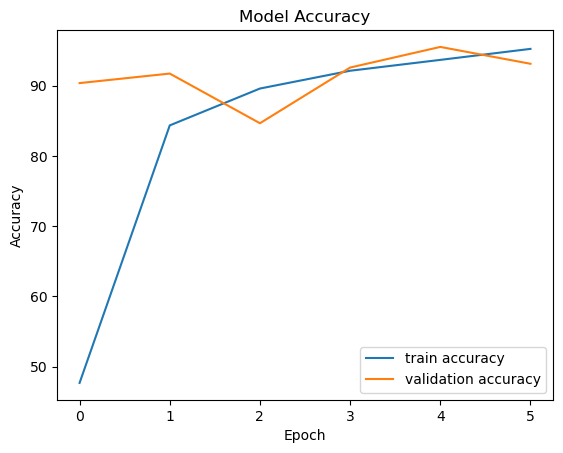

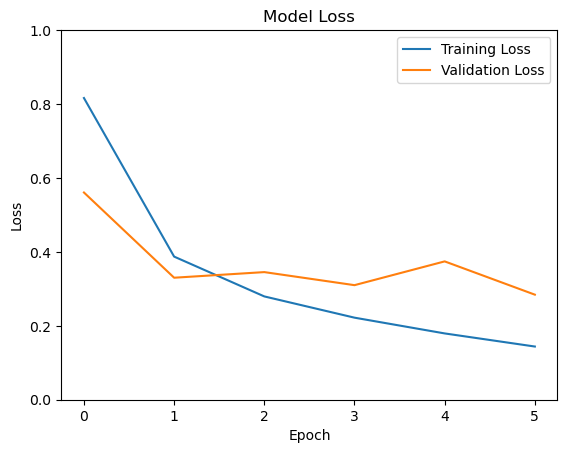

In [157]:
def generate_acc_loss_plots(history):
    
    ax = plt.figure().gca()
    plt.plot(history['train_acc'], label='train accuracy')
    plt.plot(history['val_acc'], label='validation accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1])
    plt.show()
    
generate_acc_loss_plots(history)

In [158]:
del model, train_loader, history
gc.collect()

6402

In [177]:
model1 = TransferLearningModel(len(classes))
model1 = model1.to(DEVICE)
model1.load_state_dict(torch.load('/kaggle/working/densenet161_epochs_2_batchsize_64_lr_0.0001.bin'))

model2 = TransferLearningModel(len(classes))
model2 = model2.to(DEVICE)
model2.load_state_dict(torch.load('/kaggle/working/densenet161_epochs_6_batchsize_64_lr_0.0001.bin'))

<All keys matched successfully>

In [214]:
def get_model_predictions(model, data_loader, device):
    
    model.eval()
    
    total = 0
    correct = 0
    val_accuracy = []
    val_loss = []
    y_test_all = []
    y_pred_all = []
    
    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader)):
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
            y_test_all.append(labels)
        
            y_pred = model(images.float())
            loss = criterion(y_pred, labels)

            _, predicted = torch.max(y_pred.data, 1)
            y_pred_all.append(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            
            val_accuracy.append(torch.tensor(accuracy))
            val_loss.append(torch.tensor(loss))
                    
    return val_accuracy, val_loss, y_test_all, y_pred_all

test_accuracy1, test_loss1, y_test1, y_pred1 = get_model_predictions(model=model1, data_loader=val_loader, device=DEVICE)
test_accuracy2, test_loss2, y_test2, y_pred2 = get_model_predictions(model=model2, data_loader=val_loader, device=DEVICE)

100%|██████████| 118/118 [00:32<00:00,  3.62it/s]


In [215]:
def get_flat_arrays(arrays):
    arrays = [tensor.detach().cpu().numpy() for tensor in arrays]
    arrays = np.concatenate(arrays)
    arrays = arrays.ravel()
    
    return arrays
    
y_test1 = get_flat_arrays(arrays=y_test1)
y_pred1 = get_flat_arrays(arrays=y_pred1)

y_test2 = get_flat_arrays(arrays=y_test2)
y_pred2 = get_flat_arrays(arrays=y_pred2)

In [216]:
print(classification_report(y_test1, y_pred1))
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89      2500
           1       0.94      0.89      0.91      2500
           2       0.95      0.79      0.86      2500

    accuracy                           0.89      7500
   macro avg       0.90      0.89      0.89      7500
weighted avg       0.90      0.89      0.89      7500

              precision    recall  f1-score   support

           0       0.80      0.99      0.89      2500
           1       0.91      0.90      0.90      2500
           2       0.98      0.75      0.85      2500

    accuracy                           0.88      7500
   macro avg       0.89      0.88      0.88      7500
weighted avg       0.89      0.88      0.88      7500



In [217]:
print(f"F1 Score: {f1_score(y_test1, y_pred1, average = 'weighted')}")
print(f"Precision: {precision_score(y_test1, y_pred1, average = 'weighted')}")
print(f"Recall: {recall_score(y_test1, y_pred1, average = 'weighted')}")

print(f"F1 Score: {f1_score(y_test2, y_pred2, average = 'weighted')}")
print(f"Precision: {precision_score(y_test2, y_pred2, average = 'weighted')}")
print(f"Recall: {recall_score(y_test2, y_pred2, average = 'weighted')}")

F1 Score: 0.8886475633988065
Precision: 0.8998223237515071
Recall: 0.8893333333333333
F1 Score: 0.8783189685819346
Precision: 0.8941560547931736
Recall: 0.8798666666666667


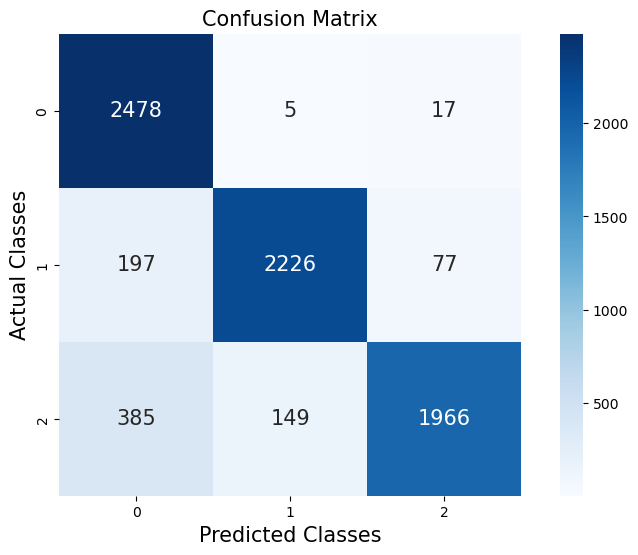

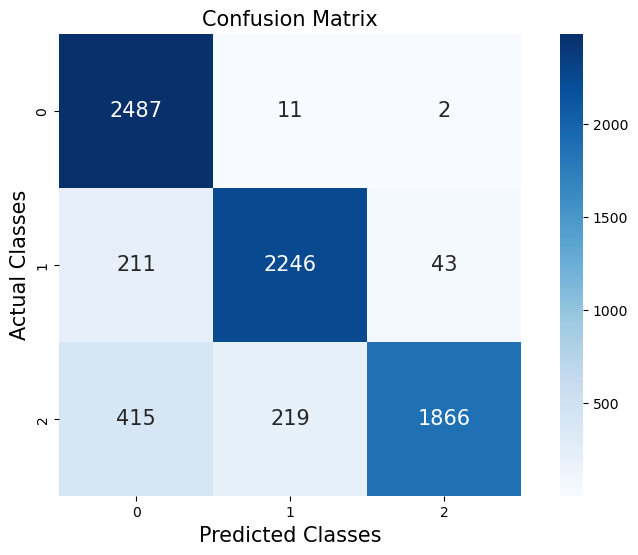

In [218]:
def plot_confusion_matrix(confusion_matrix):
    
    plt.figure(figsize = (10, 6))
    ax = plt.axes()
    ax = sns.heatmap(confusion_matrix, annot = True, square = True, fmt = "d", cmap = "Blues", cbar = True, annot_kws={'size': 15})
    ax.xaxis.set_tick_params(labelsize = 10)
    ax.yaxis.set_tick_params(labelsize = 10)
    plt.title("Confusion Matrix", fontsize = 15)
    plt.ylabel("Actual Classes", fontsize = 15)
    plt.xlabel("Predicted Classes", fontsize = 15)
    plt.show()
    
plot_confusion_matrix(confusion_matrix(y_test1, y_pred1))
plot_confusion_matrix(confusion_matrix(y_test2, y_pred2))

In [219]:
def one_hot_encode_array(array, num_classes):
    
    return np.squeeze(np.eye(num_classes)[array.reshape(-1)])

y_test1 = one_hot_encode_array(array=y_test1, num_classes=len(classes))
y_pred1 = one_hot_encode_array(array=y_pred1, num_classes=len(classes))

y_test2 = one_hot_encode_array(array=y_test2, num_classes=len(classes))
y_pred2 = one_hot_encode_array(array=y_pred2, num_classes=len(classes))

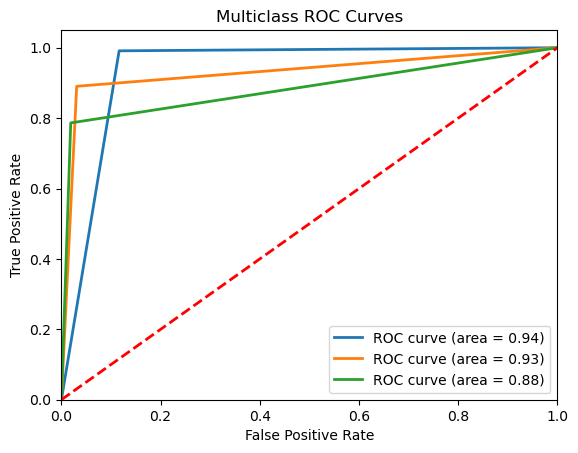

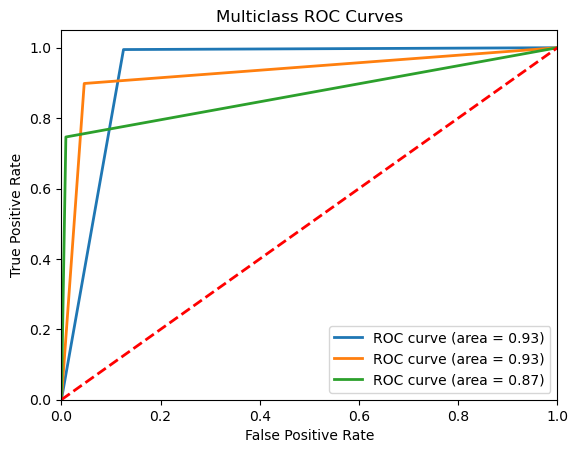

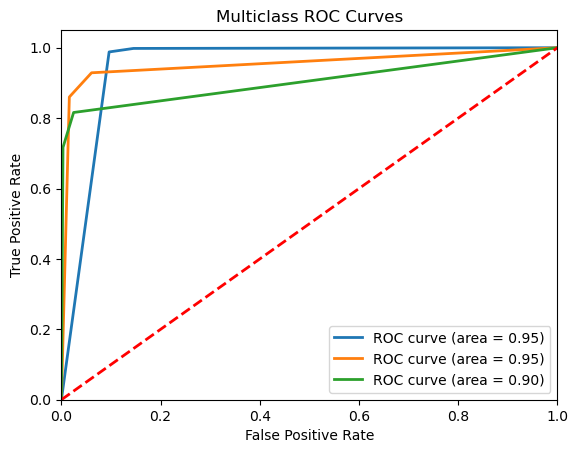

In [220]:
def plot_multiclass_roc_curves(y_test, y_pred):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(classes)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i], )
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    lw = 2
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curves')
    plt.legend(loc="lower right")
    plt.show()
    
plot_multiclass_roc_curves(y_test1, y_pred1)
plot_multiclass_roc_curves(y_test2, y_pred2)
plot_multiclass_roc_curves(np.add(y_test1, y_test2) / 2, np.add(y_pred1, y_pred2) / 2)

In [221]:
auc_score = roc_auc_score(y_test1, y_pred1, average="weighted")
print(f"AUC score: {round(auc_score * 100, 2)}")
auc_score = roc_auc_score(y_test2, y_pred2, average="weighted")
print(f"AUC score: {round(auc_score * 100, 2)}")
auc_score = roc_auc_score(np.add(y_test1, y_test2) / 2, np.add(y_pred1, y_pred2) / 2, average="weighted")
print(f"AUC score: {round(auc_score * 100, 2)}")

AUC score: 91.7
AUC score: 90.99
AUC score: 93.53
